In [27]:
# Libraries Used
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import mne

In [28]:
# Define a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter to EEG data
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return lfilter(b, a, data)


In [29]:
# Extract statistical and spectral features from EEG data <Feature Extraction>
def extract_features(eeg_data, fs=250):
    features = {}
    
    # Time-domain features
    features['mean'] = np.mean(eeg_data, axis=1)
    features['std'] = np.std(eeg_data, axis=1)
    features['min'] = np.min(eeg_data, axis=1)
    features['max'] = np.max(eeg_data, axis=1)
    
    # Frequency-domain features (Power Spectral Density)
    freqs, psd = welch(eeg_data, fs=fs, nperseg=fs*2)
    freq_bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    for band, (low, high) in freq_bands.items():
        features[f'{band}_power'] = np.sum(psd[:, (freqs >= low) & (freqs <= high)], axis=1)
    
    # Compute frequency band ratios
    features['alpha_beta_ratio'] = features['alpha_power'] / (features['beta_power'] + 1e-6)
    features['theta_alpha_ratio'] = features['theta_power'] / (features['alpha_power'] + 1e-6)

    return pd.DataFrame(features)


In [30]:
# Processing EEG data for a single subject
def process_subject(subject_folder):
    all_features = []
    for file in os.listdir(subject_folder):
        if 'eeg' in file.lower():
            eeg_file = os.path.join(subject_folder, file)
            marker_file = eeg_file.replace('eeg', 'markers')

            try:
                # Load EEG data and marker data
                eeg_data = pd.read_csv(eeg_file)
                eeg_signals = eeg_data.drop(columns=['timestamp']).values.T  # Transpose to align channels
                filtered_signals = bandpass_filter(eeg_signals, lowcut=1, highcut=50, fs=250)
                features = extract_features(filtered_signals)
                paradigm = file.split('_')[2]
                features['paradigm'] = paradigm
                all_features.append(features)
            except Exception as e:
                print(f"Error processing {file}: {e}")
    return pd.concat(all_features, axis=0) if all_features else pd.DataFrame()

# Process EEG data for 24 subjects
def process_all_subjects(base_path, num_subjects=24):
    all_subject_data = []
    for subject_id in range(1, num_subjects + 1):
        subject_folder = os.path.join(base_path, f'Subject_{subject_id}')
        subject_data = process_subject(subject_folder)
        if not subject_data.empty:
            subject_data['subject_id'] = subject_id
            all_subject_data.append(subject_data)
    return pd.concat(all_subject_data, axis=0)


In [48]:
# Visualize feature distributions and correlations
def visualize_data(data):
    plt.figure(figsize=(20, 10))
    # Correlation heatmap
    plt.subplot(1, 2, 2)
    feature_cols = [col for col in data.columns if 'power' in col]
    corr = data[feature_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')

    plt.tight_layout()
    plt.show()


In [46]:
def plot_feature_distributions(data, feature_columns):
    """
    Plot the distribution of features across different paradigms.
    
    :param data: DataFrame with extracted features.
    :param feature_columns: List of feature columns to plot.
    """
    feature_columns = [col for col in data.columns if 'power' in col]
    for feature in feature_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='paradigm', y=feature, data=data)
        plt.title(f'Distribution of {feature} by Paradigm')
        plt.xticks(rotation=45)
        plt.xlabel('Paradigm')
        plt.ylabel(feature)
        plt.show()

In [32]:
def train_classifier(data):
    label_encoder = LabelEncoder()
    data['paradigm_encoded'] = label_encoder.fit_transform(data['paradigm'])

    # Prepare features (X) and labels (y)
    X = data.drop(columns=['paradigm', 'paradigm_encoded', 'subject_id'])
    y = data['paradigm_encoded']

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

    # Feature selection using RFE (Recursive Feature Elimination)
    rf_pre = RandomForestClassifier(random_state=42)
    rfe = RFE(rf_pre, n_features_to_select=20)
    X_selected = rfe.fit_transform(X, y)

    # Train with Stratified K-Fold and Voting Classifier
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False)
    svm = SVC(kernel='rbf', probability=True)
    voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('svm', svm)], voting='soft')

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    voting_clf.fit(X_train_scaled, y_train)
    y_pred = voting_clf.predict(X_test_scaled)

    # Classification Report
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix with Task Names
    plot_confusion_matrix(y_test, y_pred, label_encoder)


In [37]:
# Confusion matrix with task names
def plot_confusion_matrix(y_test, y_pred, label_encoder, title='Confusion Matrix'):
    task_names = label_encoder.classes_  # Get the task names
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix with task names
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=task_names, yticklabels=task_names)
    plt.title(title)
    plt.xlabel('Predicted Task')
    plt.ylabel('Actual Task')
    plt.show()


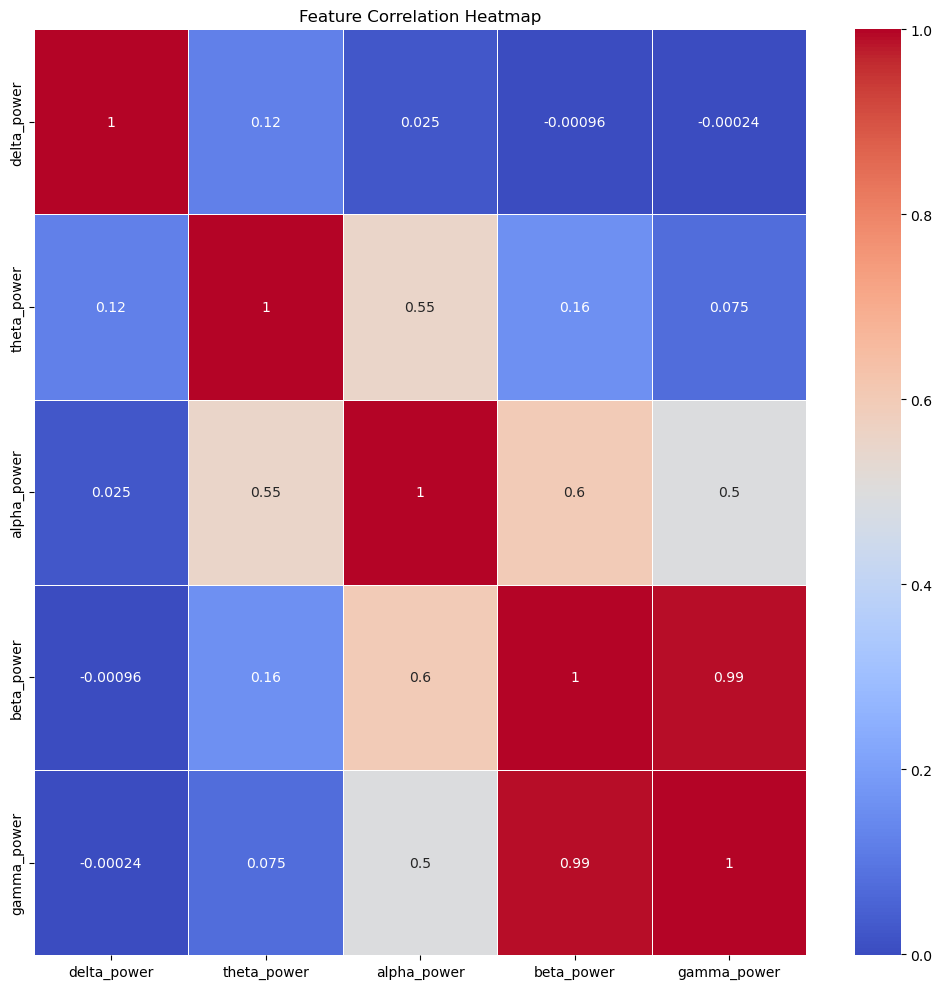

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                precision    recall  f1-score   support

      baseline       0.93      0.97      0.95        70
     dual-task       0.77      0.79      0.78        81
       oddball       0.78      0.74      0.76        85
        stroop       0.71      0.70      0.70        79
task-switching       0.68      0.68      0.68        69

      accuracy                           0.77       384
     macro avg       0.77      0.78      0.77       384
  weighted avg       0.77      0.77      0.77       384



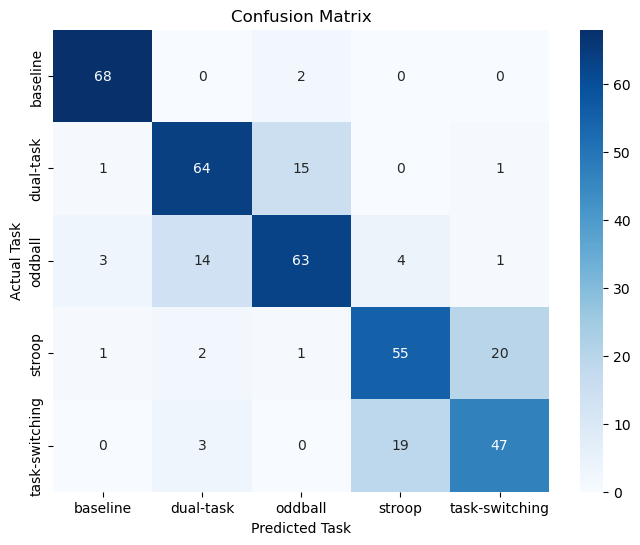

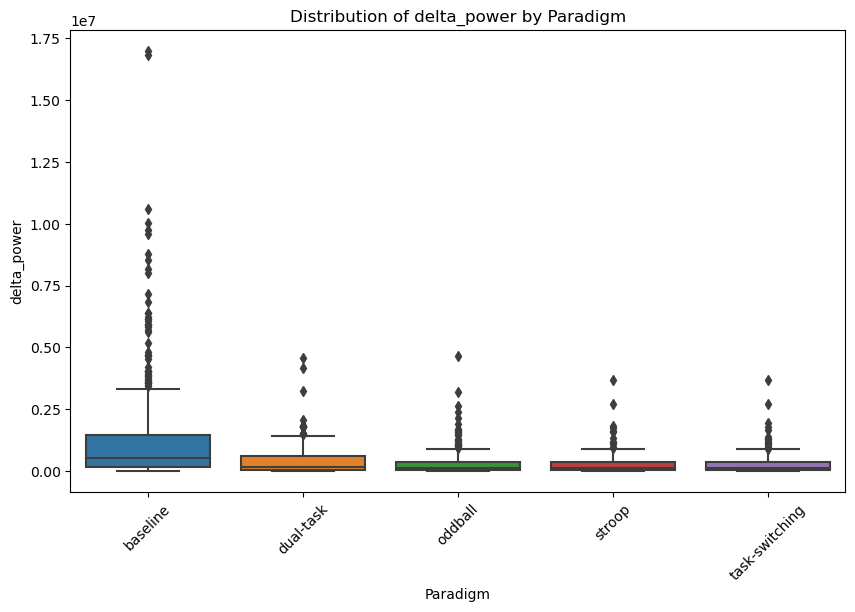

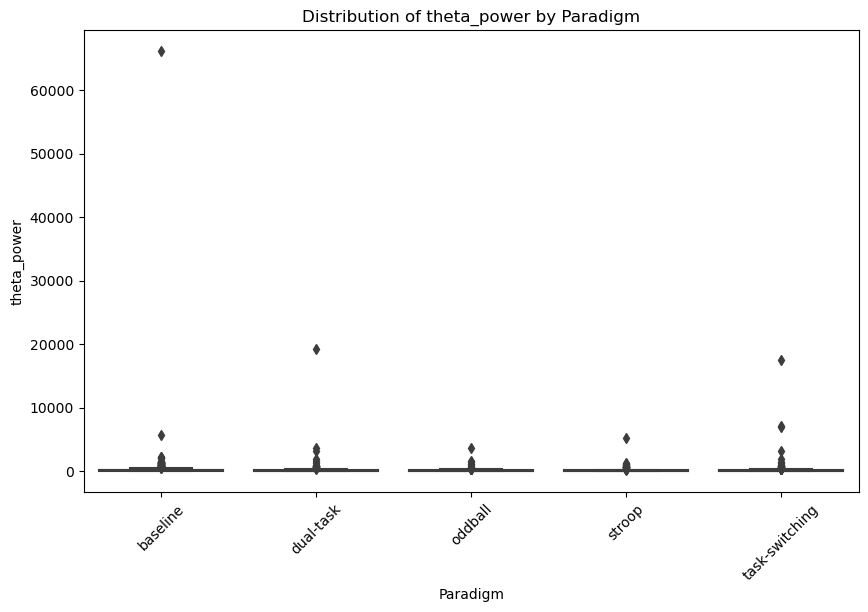

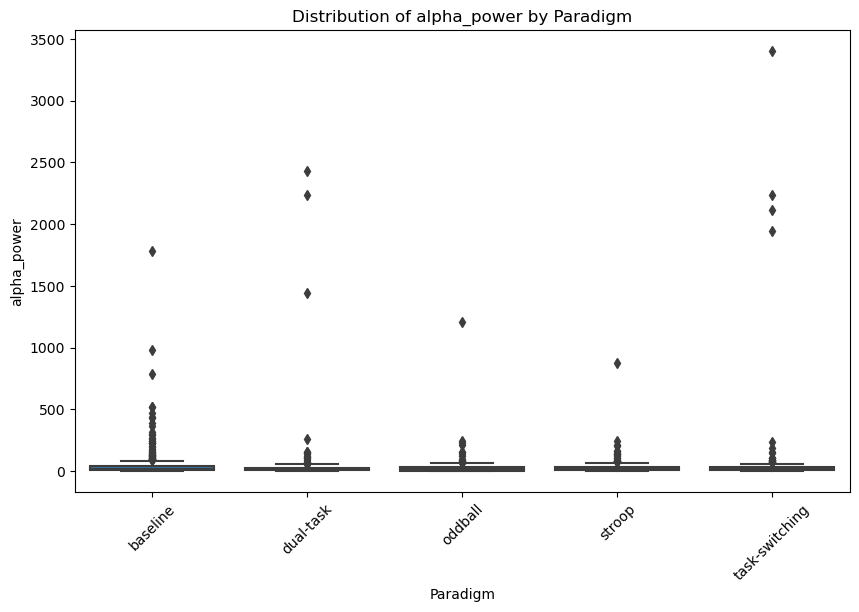

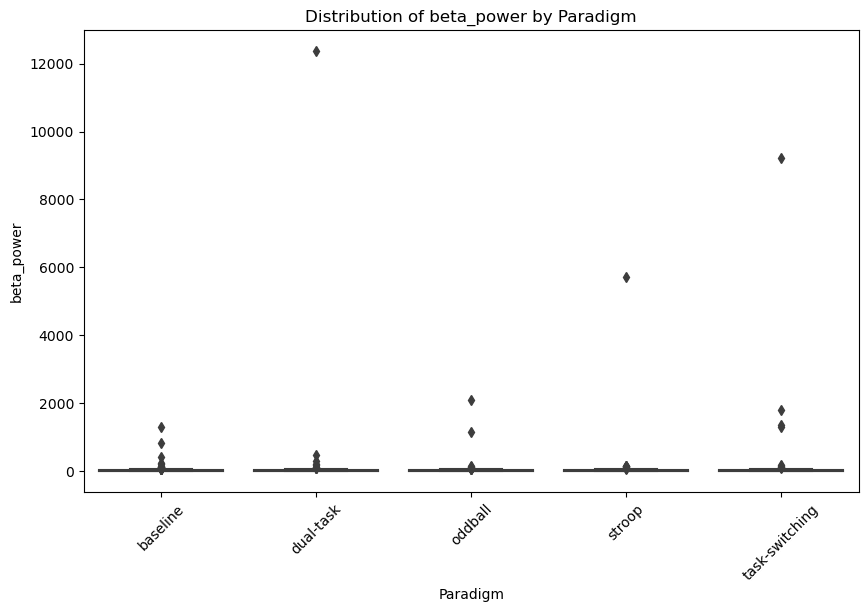

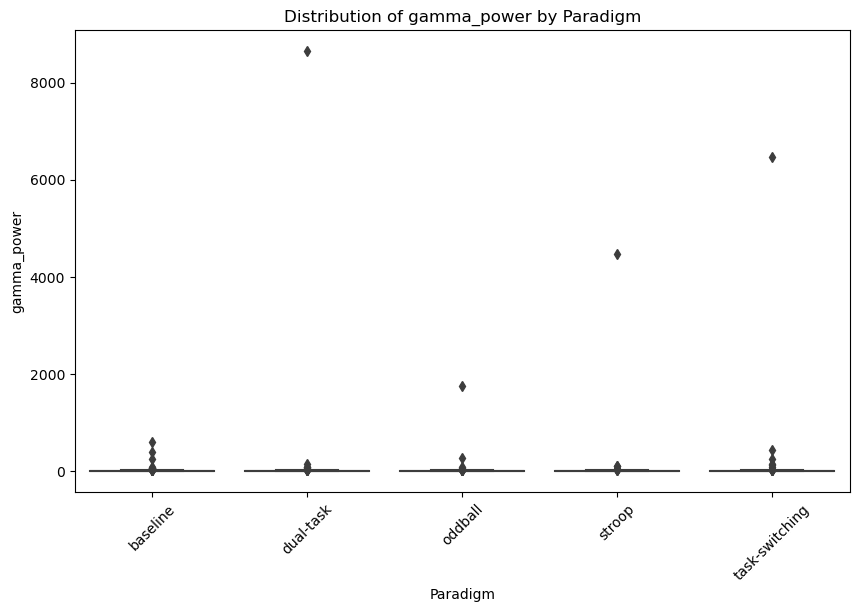

In [49]:
# Main function to process data and train classifier
def main():
    base_path = r"C:\Users\Admin\Downloads\brainathon\Brainathon-2025_Dataset"
    full_data = process_all_subjects(base_path)
    visualize_data(full_data)
    train_classifier(full_data)
    feature_columns = [col for col in full_data.columns if 'power' in col or 'mean' in col or 'std' in col]
    plot_feature_distributions(full_data, feature_columns)

if __name__ == "__main__":
    main()


In [9]:
# List all files in a given folder
def list_files_in_folder(folder):
    files = os.listdir(folder)
    print(f"Files in folder '{folder}':")
    for f in files:
        print(f"  - {f}")
    return files

# Process EEG and marker files for all subjects
def process_eeg_data_and_markers(subject_folder):
    all_eeg_data = []
    all_event_markers = []
    
    # Identify subject folders (e.g., Subject_1, Subject_2)
    subject_folders = [f for f in os.listdir(subject_folder) if os.path.isdir(os.path.join(subject_folder, f))]
    
    for subject in subject_folders:
        subject_path = os.path.join(subject_folder, subject)
        
        # List files for the subject
        files = list_files_in_folder(subject_path)
        tasks = ['baseline_eyesclosed', 'baseline_eyesopen', 'dual-task_paradigm', 
                 'oddball_paradigm', 'stroop_task', 'task-switching_paradigm']
        
        for task in tasks:
            eeg_file, marker_file = None, None
            for file in files:
                if task in file and 'eeg' in file.lower():
                    eeg_file = os.path.join(subject_path, file)
                elif task in file and 'markers' in file.lower():
                    marker_file = os.path.join(subject_path, file)
            
            if eeg_file and marker_file:
                print(f"Processing task: {task} for subject: {subject}")
                eeg_df = pd.read_csv(eeg_file)
                eeg_signals = eeg_df.drop(columns=['timestamp']).values.T  # Transpose channels
                marker_df = pd.read_csv(marker_file)
                markers = marker_df['marker'].values
                all_eeg_data.append(eeg_signals)
                all_event_markers.append(markers)
            else:
                print(f"Files missing for task: {task} in subject: {subject}")

    return all_eeg_data, all_event_markers


In [27]:
# Visualize EEG data and event markers with enhanced spectrogram and fixed topographic map
def visualize_eeg(data, eeg_data, event_markers, montage):
    if len(eeg_data) == 0:
        print("No EEG data to display.")
        return

    tasks = ['baseline_eyesclosed', 'baseline_eyesopen', 'dual-task_paradigm', 
             'oddball_paradigm', 'stroop_task', 'task-switching_paradigm']
    
    for i, task in enumerate(tasks):
        # Plot EEG time series for the first channel
        plt.figure(figsize=(10, 6))
        plt.plot(eeg_data[i][0, :], color='blue')
        plt.title(f'EEG Time Series for {task}')
        plt.xlabel('Time (samples)')
        plt.ylabel('EEG Signal (µV)')
        plt.grid(True)
        plt.show()

        # Enhanced Spectrogram
# Enhanced Spectrogram Visualization
def visualize_eeg(data, eeg_data, event_markers, montage):
    if len(eeg_data) == 0:
        print("No EEG data to display.")
        return

    tasks = ['baseline_eyesclosed', 'baseline_eyesopen', 'dual-task_paradigm', 
             'oddball_paradigm', 'stroop_task', 'task-switching_paradigm']
    
    for i, task in enumerate(tasks):
        # Plot EEG time series for the first channel
        plt.figure(figsize=(10, 6))
        plt.plot(eeg_data[i][0, :], color='blue')
        plt.title(f'EEG Time Series for {task}')
        plt.xlabel('Time (samples)')
        plt.ylabel('EEG Signal (µV)')
        plt.grid(True)
        plt.show()

        # Enhanced Spectrogram
        plt.figure(figsize=(12, 8))
        Pxx, freqs, bins, im = plt.specgram(
            eeg_data[i][0, :], 
            Fs=250, 
            NFFT=256, 
            noverlap=128, 
            cmap='plasma',  # Improved colormap for better perception
            scale='dB',     # Logarithmic scale for power
            vmin=-80,       # Dynamic range start
            vmax=-20        # Dynamic range end
        )
        plt.colorbar(im, label='Power (dB)')
        plt.title(f'Enhanced Spectrogram for {task}', fontsize=14, fontweight='bold')
        plt.xlabel('Time (s)', fontsize=12)
        plt.ylabel('Frequency (Hz)', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        # Topographic map
        eeg_data_for_topomap = eeg_data[i]
        info = mne.create_info(ch_names=['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'Cz', 'Pz', 'Oz'], 
                               ch_types=['eeg']*8, sfreq=250)
        info.set_montage(montage)

        # Plot the topographic map
        evoked = mne.EvokedArray(eeg_data_for_topomap, info, tmin=0)
        fig = evoked.plot_topomap(times=np.linspace(0, evoked.times[-1], 5), ch_type='eeg', cmap='jet')
        
        # Add a title to the figure
        plt.suptitle(f'Topographic Map for {task}', fontsize=14)
        plt.show(fig)


In [25]:
# Define EEG montage (channel locations)
montage = mne.channels.make_standard_montage('standard_1020')

# Path to dataset
subject_folder = r"C:\Users\Admin\Downloads\brainathon\Brainathon-2025_Dataset"

# Process EEG and marker data
eeg_data, event_markers = process_eeg_data_and_markers(subject_folder)

# Placeholder for combined visualization data (if required later)
data = pd.DataFrame()


Files in folder 'C:\Users\Admin\Downloads\brainathon\Brainathon-2025_Dataset\Subject_1':
  - Subject_1_baseline_eyesclosed_eeg.csv
  - Subject_1_baseline_eyesclosed_markers.csv
  - Subject_1_baseline_eyesopen_eeg.csv
  - Subject_1_baseline_eyesopen_markers.csv
  - Subject_1_dual-task_paradigm_eeg.csv
  - Subject_1_dual-task_paradigm_markers.csv
  - Subject_1_oddball_paradigm_eeg.csv
  - Subject_1_oddball_paradigm_markers.csv
  - Subject_1_stroop_task_eeg.csv
  - Subject_1_stroop_task_markers.csv
  - Subject_1_task-switching_paradigm_eeg.csv
  - Subject_1_task-switching_paradigm_markers.csv
Processing task: baseline_eyesclosed for subject: Subject_1
Processing task: baseline_eyesopen for subject: Subject_1
Processing task: dual-task_paradigm for subject: Subject_1
Processing task: oddball_paradigm for subject: Subject_1
Processing task: stroop_task for subject: Subject_1
Processing task: task-switching_paradigm for subject: Subject_1
Files in folder 'C:\Users\Admin\Downloads\brainathon\

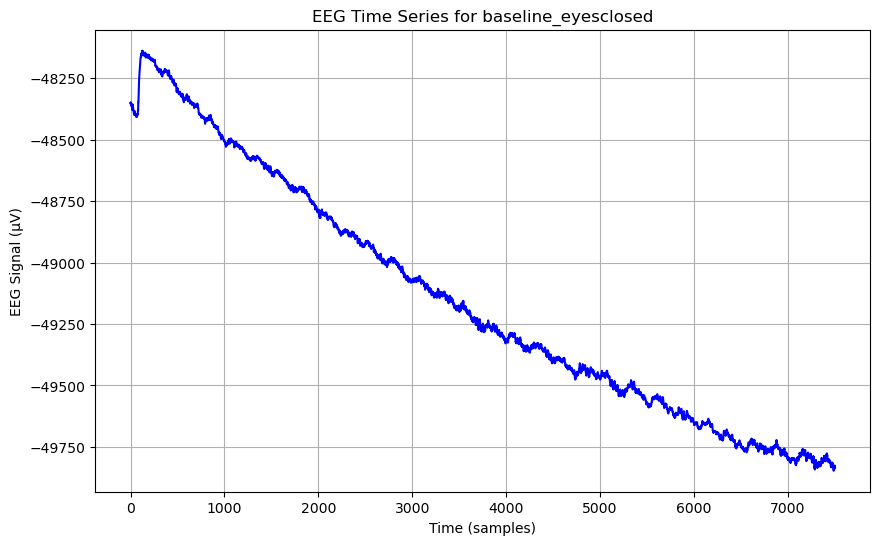

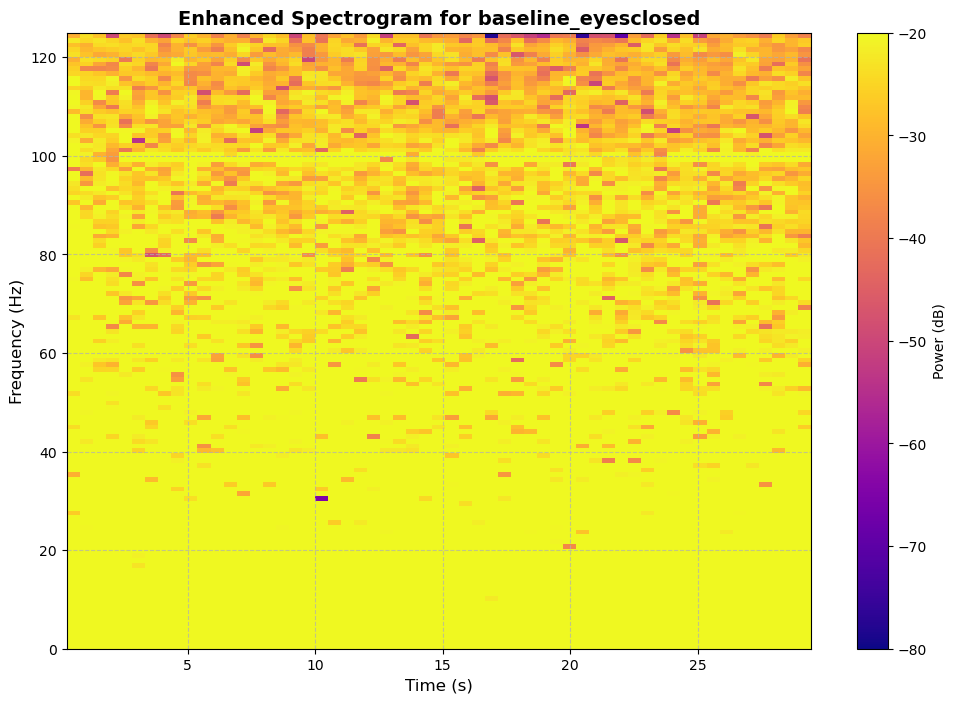

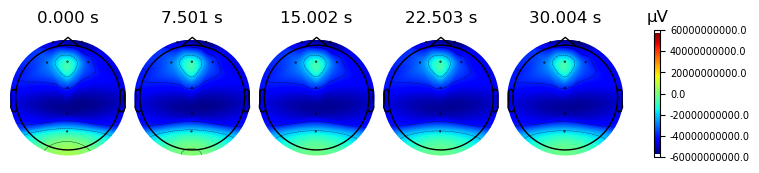

<Figure size 640x480 with 0 Axes>

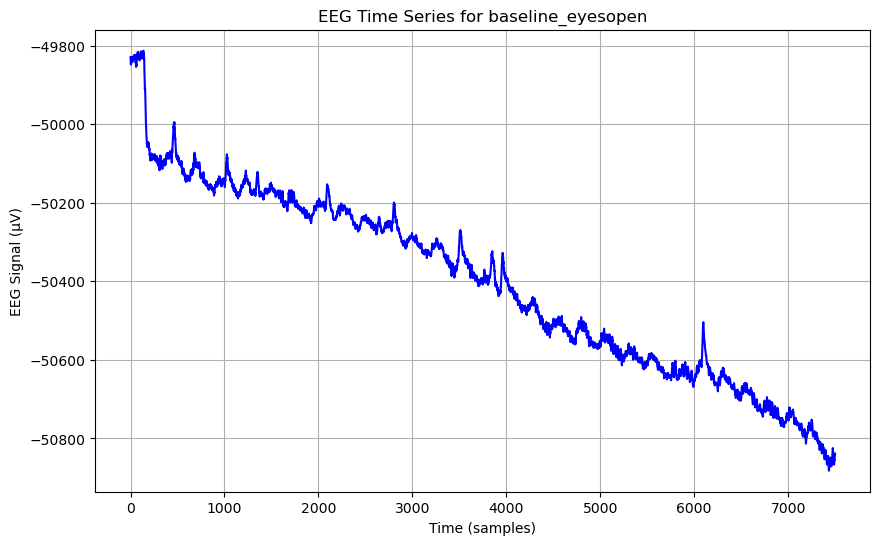

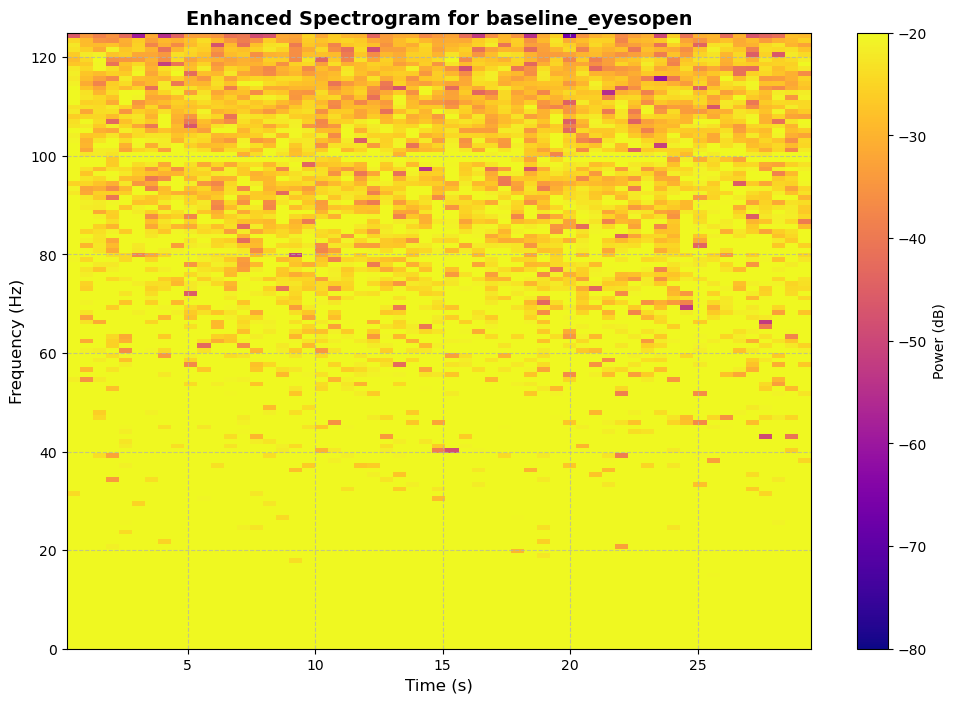

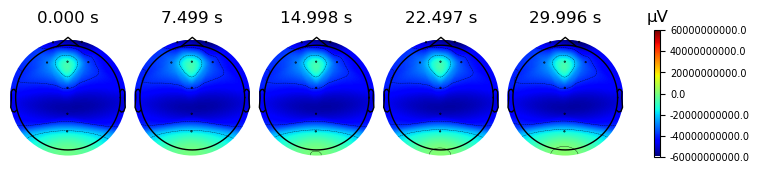

<Figure size 640x480 with 0 Axes>

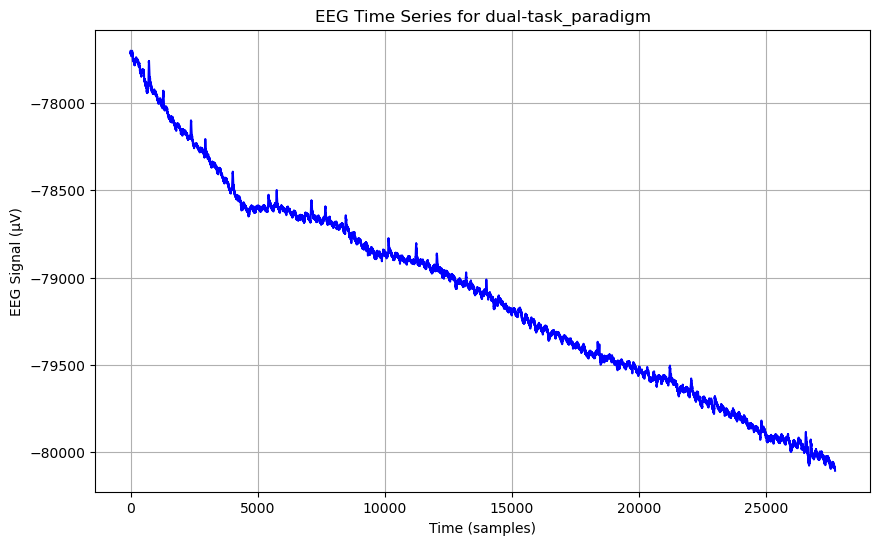

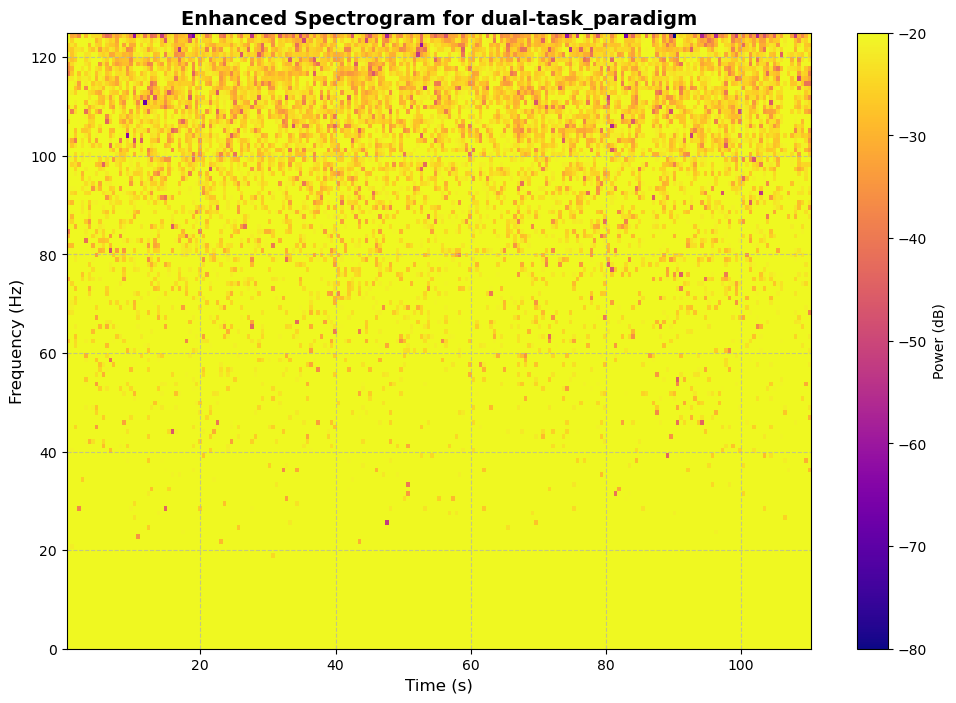

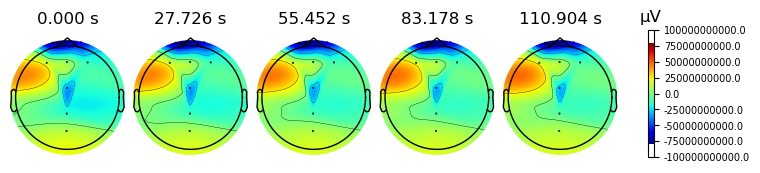

<Figure size 640x480 with 0 Axes>

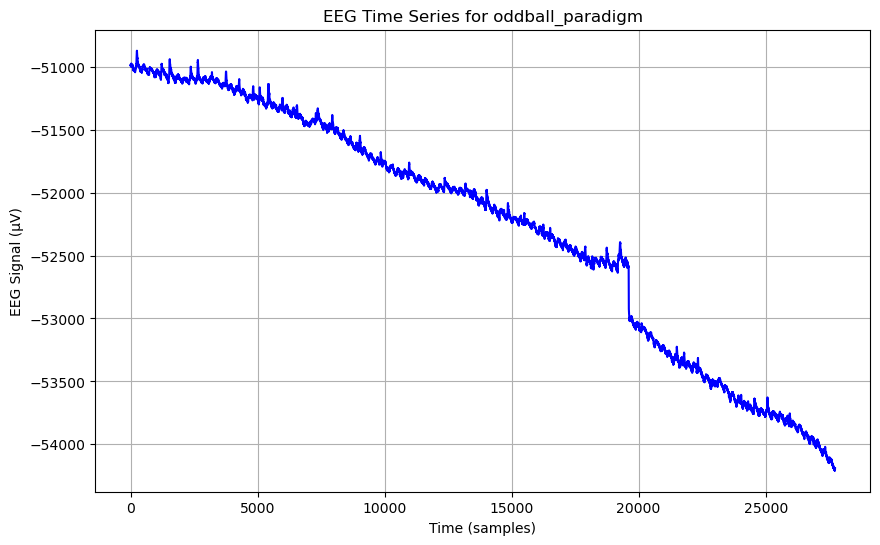

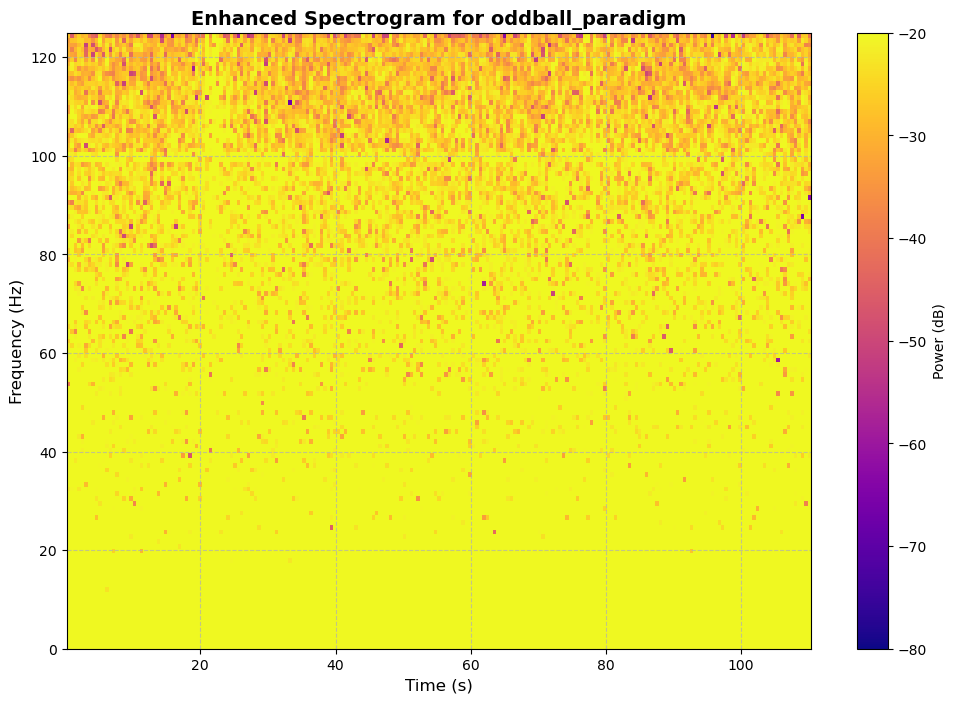

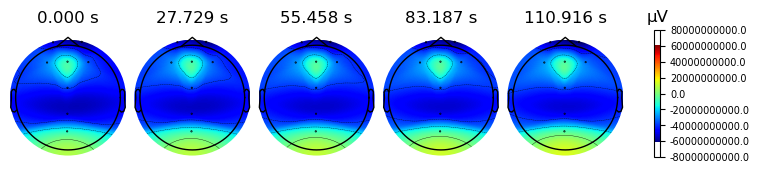

<Figure size 640x480 with 0 Axes>

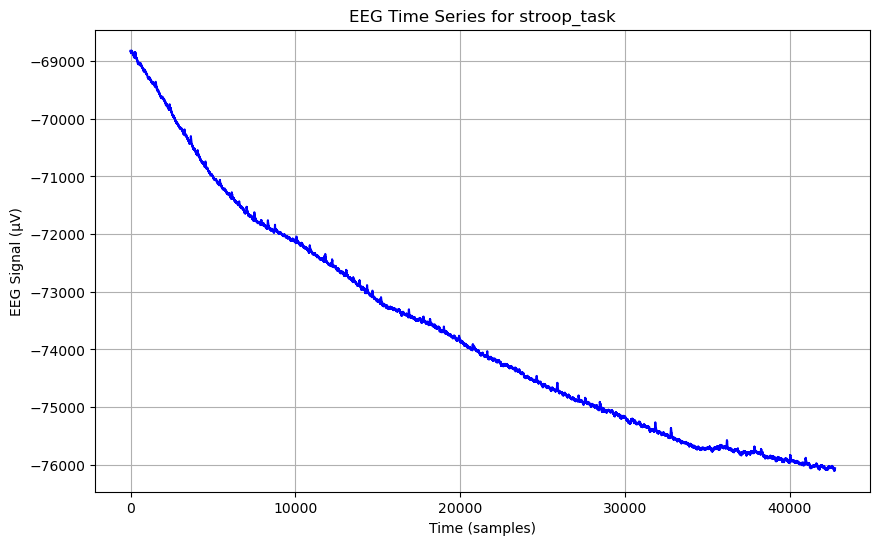

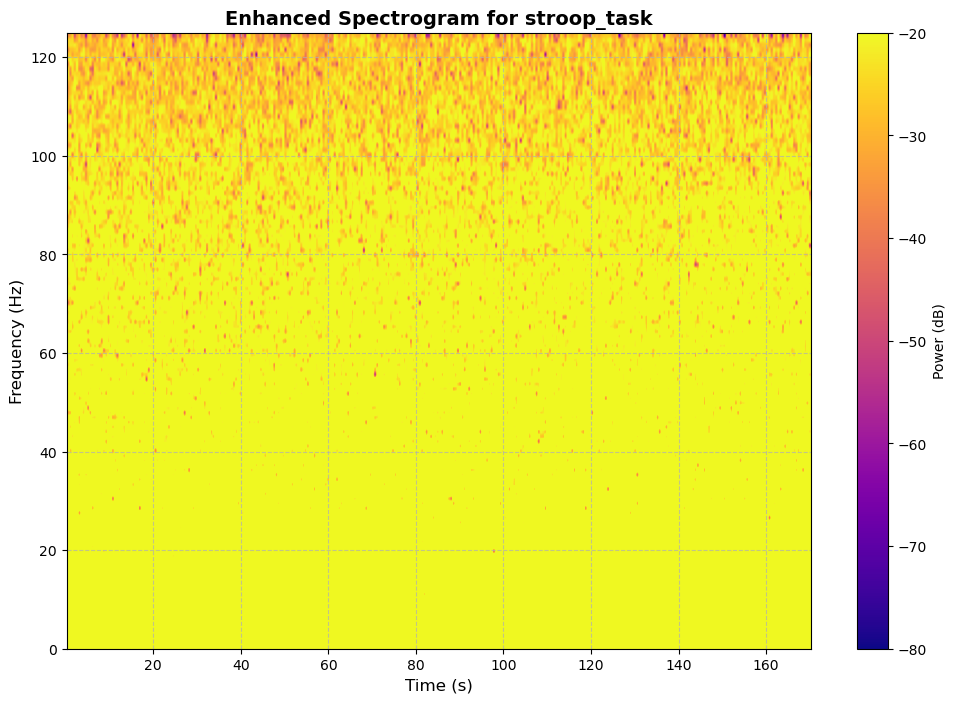

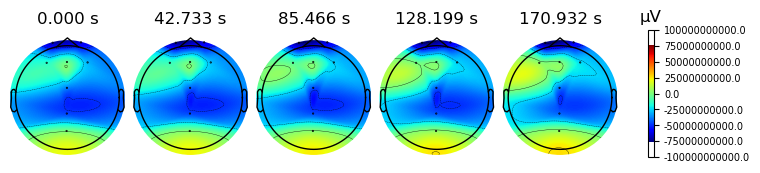

<Figure size 640x480 with 0 Axes>

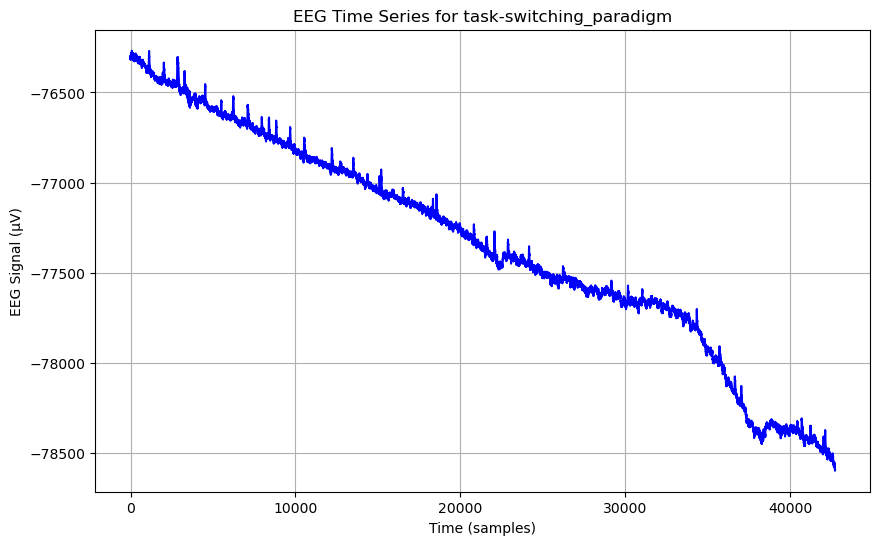

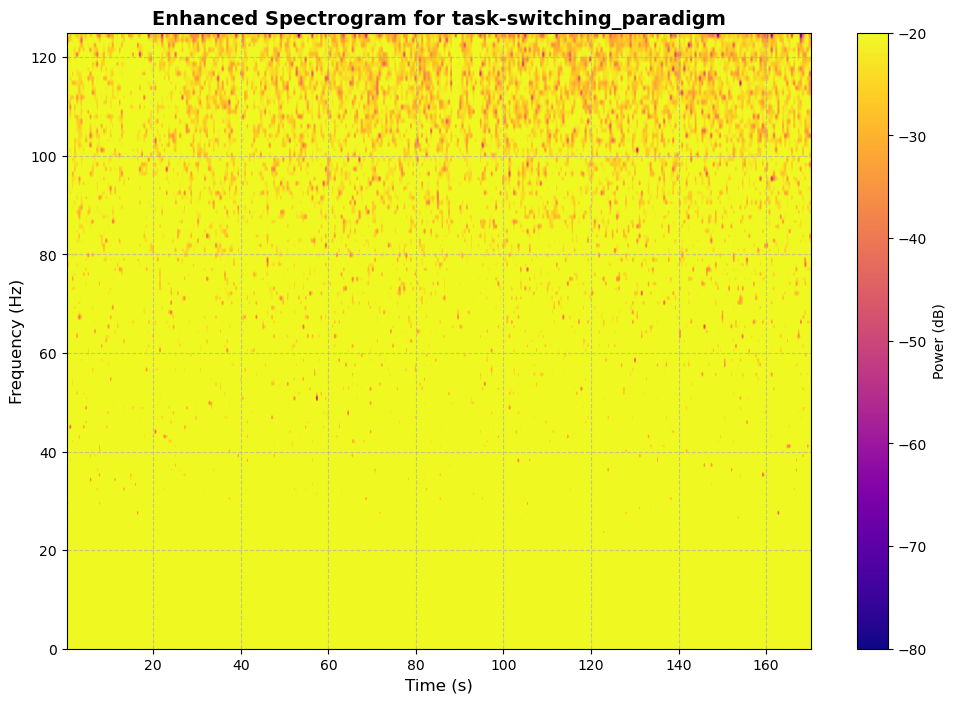

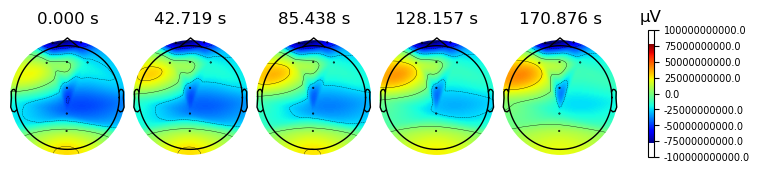

<Figure size 640x480 with 0 Axes>

In [28]:
# Visualize EEG and event markers
visualize_eeg(data=data, eeg_data=eeg_data, event_markers=event_markers, montage=montage)